# Reinforce (Policy Gradient)

#### Basic Idea
Do a bunch of random stuff, see what works better and do it more of the things that work nice in the future. Mathematically speaking you want to maximize:
$$\sum_i{log p(y_i|x_i)}$$

Here we have the following:
* $y_i$ : Some action at time step i
* $x_i$ : Some state at time step i
* $p$ : Policy, some function that does some action given some state

The problem is that on Reinforcement Learning we don't have $y_i$ so we need to sample $$y_i \sim p(\bullet|x_i)$$

#### Imagine Policy Gradients as Supervised Learning
Imagine someone gave you batches of rollouts (several actions and the result WIN/LOOSE),

![alt text](docs/imgs/RL_PG_1.png "Supervised RL")

Now we modulate the log probability depending on the result, for example if we win:

$$(+1).(log p(y_i|x_i))$$ 

and if we loose:

$$(-1).(log p(y_i|x_i))$$

This modulating factor we call it Advantage Function $A_i$ , and in Reinforcement Learning there are several ways to define this function.
$$\sum_i{A_i * log p(y_i|x_i)}$$

#### Pros and Cons of Policy Gradeints
##### Advantages of Policy Gradient Methods
* Works with continous action spaces
* Automatically explore (Because we just sample from our output)

#### Installing
```bash
pip install --user --upgrade tf-agents-nightly  # depends on tf-nightly
pip install tfp-nightly

```

#### References
* https://www.youtube.com/watch?v=tqrcjHuNdmQ
* https://www.youtube.com/watch?v=S_gwYj1Q-44
* https://www.youtube.com/watch?v=-TTziY7EmUA
* https://www.youtube.com/watch?v=tAOApRQAgpc
* https://github.com/tensorflow/agents/tree/master/tf_agents/colabs
* https://github.com/tensorflow/agents/blob/master/tf_agents/colabs/6_reinforce_tutorial.ipynb
* https://pybullet.org/wordpress/

In [1]:
import rl_utils as utils

import tensorflow as tf

from tf_agents.agents.reinforce import reinforce_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

env_name = "CartPole-v0" # @param {type:"string"}
num_iterations = 250 # @param {type:"integer"}
collect_episodes_per_iteration = 2 # @param {type:"integer"}
replay_buffer_capacity = 2000 # @param {type:"integer"}

fc_layer_params = (100,)

learning_rate = 1e-3 # @param {type:"number"}
log_interval = 25 # @param {type:"integer"}
num_eval_episodes = 10 # @param {type:"integer"}
eval_interval = 50 # @param {type:"integer"}

#### Load the Environment
Here we will use the OpenAI Gym Environment

In [2]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

#### Define the Policy Neural Network
Sometimes this is also called "Actor Network".

In [3]:
actor_net = actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

#### Define the RL Algorithm

In [4]:
train_step_counter = tf.compat.v2.Variable(0)

tf_agent = reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()


In [5]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

In [6]:
def compute_avg_return(environment, policy, num_episodes=10):    
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]


#### Define Replay Buffer

In [7]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=tf_agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

In [8]:
def collect_episode(environment, policy, num_episodes):

    episode_counter = 0
    environment.reset()

    while episode_counter < num_episodes:
        time_step = environment.current_time_step()
        action_step = policy.action(time_step)
        next_time_step = environment.step(action_step.action)
        traj = trajectory.from_transition(time_step, action_step, next_time_step)

        # Add trajectory to the replay buffer
        replay_buffer.add_batch(traj)

        if traj.is_boundary():
            episode_counter += 1

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

#### Train(or Play)

In [9]:
%%time

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
tf_agent.train = common.function(tf_agent.train)

# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

    # Collect a few episodes using collect_policy and save to the replay buffer.
    collect_episode(
      train_env, tf_agent.collect_policy, collect_episodes_per_iteration)

    # Use data from the buffer and update the agent's network.
    experience = replay_buffer.gather_all()
    train_loss = tf_agent.train(experience)
    replay_buffer.clear()

    step = tf_agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss.loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

step = 25: loss = -0.11647284030914307
step = 50: loss = -0.765430212020874
step = 50: Average Return = 90.30000305175781
step = 75: loss = -0.435870885848999
step = 100: loss = 0.20807623863220215
step = 100: Average Return = 155.3000030517578
step = 125: loss = -0.016495466232299805
step = 150: loss = -0.5183595418930054
step = 150: Average Return = 148.5
step = 175: loss = -1.2367452383041382
step = 200: loss = -4.841897964477539
step = 200: Average Return = 200.0
step = 225: loss = -1.4532756805419922
step = 250: loss = -6.52463436126709
step = 250: Average Return = 200.0
CPU times: user 1min 59s, sys: 484 ms, total: 1min 59s
Wall time: 1min 59s


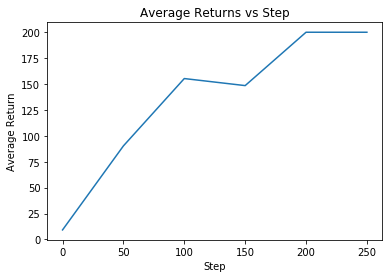

In [10]:
steps = range(0, num_iterations + 1, eval_interval)
utils.plot_avg_returns_by_step(steps, returns)

In [11]:
num_episodes = 3
video_filename = 'imageio.mp4'
utils. make_video(video_filename, eval_env, eval_py_env, tf_agent, num_episodes=num_episodes)
utils.embed_mp4(video_filename)

NameError: name 'eval_py_env' is not defined